In [1]:
import copy
import dicom2nifti
import dicom2nifti.compressed_dicom as compressed_dicom
import importlib
import niftiutils.helper_fxns as hf
import niftiutils.transforms as tr
import niftiutils.registration as regs
import niftiutils.visualization as vis
import keras
import keras.layers as layers
import numpy as np
import os
import pandas as pd
import pylab
import shutil
import config
import cnn_builder as cbuild
from keras.models import Model
import dcgan as dcg
from keras.callbacks import EarlyStopping
%matplotlib inline

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [13]:
importlib.reload(config)
importlib.reload(cbuild)
C = config.Config()

model = cbuild.build_cnn(lr=.01)
model.summary()

#early_stopping = EarlyStopping(monitor='loss', min_delta=0.001, patience=3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 32)        0         
_________________________________________________________________
reshape_7 (Reshape)          (None, 64, 2048)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 64, 1024)          2097152   
_________________________________________________________________
reshape_8 (Reshape)          (None, 64, 32, 32, 1)     0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 64, 32, 32, 64)    1792      
_________________________________________________________________
up_sampling3d_3 (UpSampling3 (None, 64, 64, 64, 64)    0         
_________________________________________________________________
conv3d_6 (Conv3D)            (None, 64, 64, 64, 64)    110592    
__________

In [ ]:
hist = model.fit_generator(cbuild.train_generator(), steps_per_epoch=10, epochs=50)#, callbacks=[early_stopping])

Epoch 1/50
10/10 [==============================] - 4s 384ms/step - loss: 329.0167
Epoch 2/50
10/10 [==============================] - 3s 319ms/step - loss: 211.2242
Epoch 3/50
10/10 [==============================] - 3s 319ms/step - loss: 162.1578
Epoch 4/50
10/10 [==============================] - 3s 335ms/step - loss: 131.5128
Epoch 5/50
10/10 [==============================] - 3s 330ms/step - loss: 109.7527
Epoch 6/50
10/10 [==============================] - 3s 333ms/step - loss: 93.2498
Epoch 7/50
10/10 [==============================] - 3s 327ms/step - loss: 80.2297
Epoch 8/50
10/10 [==============================] - 3s 332ms/step - loss: 69.6571
Epoch 9/50
10/10 [==============================] - 3s 330ms/step - loss: 60.8958
Epoch 10/50
10/10 [==============================] - 3s 332ms/step - loss: 53.5146
Epoch 11/50
10/10 [==============================] - 3s 333ms/step - loss: 47.2270
Epoch 12/50
10/10 [==============================] - 3s 335ms/step - loss: 41.8073
Epoch 13

In [ ]:
X,Y=next(cbuild.train_generator())

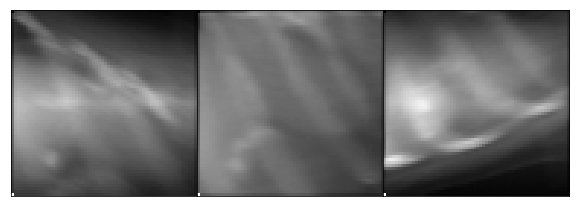

In [6]:
vis.draw_slices(X[0], normalize=[0,1])

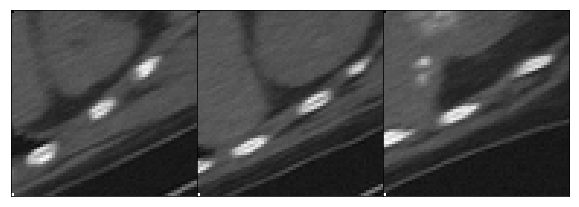

In [7]:
vis.draw_slices(Y[0], normalize=[0,1])

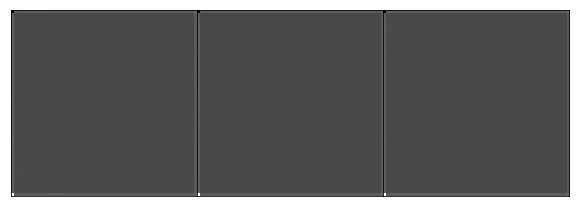

In [12]:
y_pred = model.predict(X[:1])[0]
#y_pred = dcgan.generator.predict(X[:1])[0]
vis.draw_slices(y_pred, normalize=[0,1])

In [ ]:
layers.Dense()

In [477]:
importlib.reload(dcg)
dcgan = dcg.DCGAN()
dcgan.train(epochs=4000, batch_size=4, save_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       (None, 64, 64, 64)        0         
_________________________________________________________________
reshape_189 (Reshape)        (None, 64, 64, 64, 1)     0         
_________________________________________________________________
conv3d_118 (Conv3D)          (None, 30, 30, 30, 64)    8064      
_________________________________________________________________
conv3d_119 (Conv3D)          (None, 15, 15, 15, 64)    512064    
_________________________________________________________________
batch_normalization_306 (Bat (None, 15, 15, 15, 64)    256       
_________________________________________________________________
conv3d_120 (Conv3D)          (None, 8, 8, 8, 64)       110656    
_________________________________________________________________
flatten_24 (Flatten)         (None, 32768)             0         
__________

C:\Users\Clinton\AppData\Local\conda\conda\envs\old-keras\lib\site-packages\keras-2.1.2-py3.5.egg\keras\engine\training.py:945: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.869358, acc.: 25.00%] [G loss: 0.091760] [C loss: 0.759130]
1 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.403146]
2 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.702126]
3 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.997310]
4 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.272192]
5 [D loss: 1.044851, acc.: 50.00%] [G loss: 0.000000] [C loss: 1.333566]
6 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.695205]
7 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.801366]
8 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.763147]
9 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.873850]
10 [D loss: 1.688904, acc.: 37.50%] [G loss: 0.139875] [C loss: 0.884974]
11 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.842039]
12 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.995156]
13 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C l

112 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.957321]
113 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.852968]
114 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.030822]
115 [D loss: 3.316183, acc.: 62.50%] [G loss: 0.000000] [C loss: 1.640477]
116 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.962391]
117 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.376124]
118 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.424235]
119 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.012762]
120 [D loss: 2.929842, acc.: 50.00%] [G loss: 0.103846] [C loss: 4.221187]
121 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.815192]
122 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.792801]
123 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.796348]
124 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 3.673222]
125 [D loss: 4.853926, acc.: 62.50%]

223 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.997745]
224 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.715639]
225 [D loss: 2.191149, acc.: 50.00%] [G loss: 0.000000] [C loss: 2.226739]
226 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.965204]
227 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.436753]
228 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 2.002462]
229 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.117511]
230 [D loss: 1.277242, acc.: 62.50%] [G loss: 0.114088] [C loss: 1.916351]
231 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.332123]
232 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.617348]
233 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.431136]
234 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.137460]
235 [D loss: 0.880724, acc.: 50.00%] [G loss: 0.000000] [C loss: 2.151270]
236 [D loss: 0.000000, acc.: 0.00%]

334 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.988102]
335 [D loss: 2.714291, acc.: 50.00%] [G loss: 0.000000] [C loss: 1.386317]
336 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.831636]
337 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.685584]
338 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.357565]
339 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.236555]
340 [D loss: 2.443246, acc.: 62.50%] [G loss: 0.044795] [C loss: 0.951042]
341 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.118200]
342 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.613917]
343 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.656281]
344 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.648113]
345 [D loss: 2.245312, acc.: 37.50%] [G loss: 0.000000] [C loss: 1.093167]
346 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 1.557252]
347 [D loss: 0.000000, acc.: 0.00%]

445 [D loss: 1.529968, acc.: 37.50%] [G loss: 0.000000] [C loss: 0.647949]
446 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.652776]
447 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.646731]
448 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.647050]
449 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.647337]
450 [D loss: 0.940492, acc.: 25.00%] [G loss: 0.027989] [C loss: 0.627718]
451 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.625696]
452 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.624532]
453 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.655004]
454 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.624120]
455 [D loss: 1.702496, acc.: 37.50%] [G loss: 0.000000] [C loss: 0.628460]
456 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.627344]
457 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.627759]
458 [D loss: 0.000000, acc.: 0.00%]

556 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.878996]
557 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.879006]
558 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.878990]
559 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.878995]
560 [D loss: 2.400057, acc.: 75.00%] [G loss: 0.021077] [C loss: 0.887906]
561 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.887912]
562 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.887907]
563 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.887906]
564 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.887909]
565 [D loss: 2.550058, acc.: 75.00%] [G loss: 0.000000] [C loss: 0.933655]
566 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.933660]
567 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.933660]
568 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.933652]
569 [D loss: 0.000000, acc.: 0.00%] 

667 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.782543]
668 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.782544]
669 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.782546]
670 [D loss: 2.174588, acc.: 75.00%] [G loss: 0.017713] [C loss: 0.794036]
671 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.794035]
672 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.794035]
673 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.794037]
674 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.794036]
675 [D loss: 1.493868, acc.: 75.00%] [G loss: 0.000000] [C loss: 0.793378]
676 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.793375]
677 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.793380]
678 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.793377]
679 [D loss: 0.000000, acc.: 0.00%] [G loss: 0.000000] [C loss: 0.793381]
680 [D loss: 2.249876, acc.: 87.50%]

KeyboardInterrupt: 

In [73]:
img_dir = r"D:\CBCT\AARON"
dcm_path = img_dir+"\\15814.dcm"

In [74]:
dicom_input = compressed_dicom.read_file(dcm_path,
                                       defer_size=100,
                                       stop_before_pixels=False,
                                       force=False)

In [75]:
cine_rate = float(dicom_input[('0018', '0040')].value)
kvp = float(dicom_input[('0018', '0060')].value)
d_detector = int(dicom_input[('0018', '1110')].value)
d_patient = int(dicom_input[('0018', '1111')].value)
t_exposure = int(dicom_input[('0018', '1150')].value)
current = int(dicom_input[('0018', '1151')].value)
exposure = int(dicom_input[('0018', '1152')].value)
pixel_spacing = dicom_input[('0018', '1164')].value
angle1 = float(dicom_input[('0018', '1510')].value)
angle2 = float(dicom_input[('0018', '1511')].value)
angle1_increment = dicom_input[('0018', '1520')].value
angle2_increment = dicom_input[('0018', '1521')].value
shutter_edges = [int(dicom_input[('0018', str(x))].value) for x in [1602, 1604, 1606, 1608]]

In [ ]:
proj_imgs, _ = hf.dcm_load(dcm_path)
proj_imgs = np.transpose(proj_imgs, (1,2,0))
proj_imgs_unscaled = copy.deepcopy(proj_imgs)
proj_imgs = (proj_imgs - np.amin(proj_imgs)) / (np.amax(proj_imgs) - np.amin(proj_imgs))

In [82]:
proj_imgs = proj_imgs[:, :, 50:-50]
rows, frames, cols = proj_imgs.shape

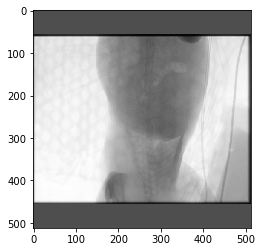

In [83]:
pylab.imshow(proj_imgs[:,100,:], cmap='gray')

In [84]:
proj_imgs.shape

(512, 308, 512)

In [ ]:
import astra

In [394]:
rec_cropped = rec[:,10:120,20:170]
rec_cropped[rec_cropped < 0] = 0
rec_cropped = np.transpose(rec_cropped, (2,1,0))

In [395]:
rec_cropped = rec_cropped * -1

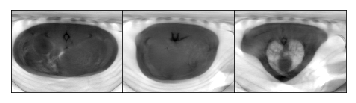

In [366]:
hf.draw_slices(rec_cropped)

In [306]:
print(np.amin(rec[80,10:120,20:170]), np.amax(rec[80,10:120,20:170]))

-59.913471

pylab.imshow(np.transpose(rec[:,:,::-1][50,20:170,10:120], (1,0)), vmin=0.0005)

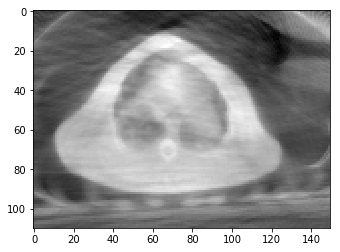

In [23]:
pylab.imshow(rec[100,10:120,20:170])#, vmin=-50, vmax=150) #vmin=.0010, vmax=0.0035)

In [27]:
recon_img = hf.dcm_load(img_dir+"\\15810.dcm")
recon_img = np.transpose(recon_img, (1,2,0))[::-1,:,:]